In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# Install TensorFlow if not already installed
try:
    import tensorflow as tf
except ImportError:
    !pip install tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Import layers from tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import BatchNormalization

import numpy as np
import pylab as plt


: 

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anikannal/solar-power-generation-data")

print("Path to dataset files:", path)
path1= path+'/Plant_1_Generation_Data.csv'
path2= path+'/Plant_1_Weather_Sensor_Data.csv'

100%|██████████| 1.90M/1.90M [00:00<00:00, 119MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/anikannal/solar-power-generation-data/versions/1


In [4]:
df_gen1=pd.read_csv(path1)
df_sens1=pd.read_csv(path2)

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
import warnings
warnings.filterwarnings('ignore')



def prepare_data_no_scaling(df_gen1, df_sens1):
   
    print("Preparing dataset WITHOUT scaling...")


    df_gen1['DATE_TIME'] = pd.to_datetime(df_gen1['DATE_TIME'], format='%d-%m-%Y %H:%M')
    df_sens1['DATE_TIME'] = pd.to_datetime(df_sens1['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

    
    df_combined = pd.merge(
        df_gen1[['DATE_TIME', 'DC_POWER']],
        df_sens1[['DATE_TIME', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']],
        on='DATE_TIME'
    )

    
    df_combined = df_combined.sort_values('DATE_TIME').reset_index(drop=True)

    

    
    df_combined = df_combined.fillna(method='ffill').fillna(method='bfill')

    
    df_combined = df_combined[
        (df_combined['IRRADIATION'] >= 0) &
        (df_combined['DC_POWER'] >= 0) &
        (df_combined['AMBIENT_TEMPERATURE'] > -50) &  
        (df_combined['AMBIENT_TEMPERATURE'] < 60) &
        (df_combined['MODULE_TEMPERATURE'] > -50) &
        (df_combined['MODULE_TEMPERATURE'] < 100)
    ].reset_index(drop=True)

    print(f"Combined dataset shape: {df_combined.shape}")
    print(f"Date range: {df_combined['DATE_TIME'].min()} to {df_combined['DATE_TIME'].max()}")
    print(f"DC Power range: {df_combined['DC_POWER'].min():.1f} to {df_combined['DC_POWER'].max():.1f} kW")
    print(f"Irradiation range: {df_combined['IRRADIATION'].min():.1f} to {df_combined['IRRADIATION'].max():.1f}")
    print(f"Temperature range: {df_combined['AMBIENT_TEMPERATURE'].min():.1f} to {df_combined['AMBIENT_TEMPERATURE'].max():.1f}°C")

    return df_combined

def create_enhanced_sequences(df_combined, window_size=24):
   
    print("Creating basic feature sequences without scaling...")

    
    input_features = [
        'IRRADIATION',           
        'AMBIENT_TEMPERATURE',   
        'MODULE_TEMPERATURE',    
    ]

    target_col = 'DC_POWER'

    
    missing_cols = [col for col in input_features if col not in df_combined.columns]
    if missing_cols:
        raise ValueError(f"Missing columns: {missing_cols}")

    print(f"Input features: {input_features}")
    print(f"Target: {target_col}")

    
    feature_data = df_combined[input_features].values
    target_data = df_combined[target_col].values

    
    for i, feature in enumerate(input_features):
        print(f"{feature}: {feature_data[:, i].min():.2f} to {feature_data[:, i].max():.2f}")

    
    X_sequences = []
    y_sequences = []

    for i in range(len(feature_data) - window_size):
        X_sequences.append(feature_data[i:(i + window_size)])
        y_sequences.append(target_data[i + window_size])

    X = np.array(X_sequences, dtype=np.float32)
    y = np.array(y_sequences, dtype=np.float32)

    print(f"Sequence shapes - X: {X.shape}, y: {y.shape}")
    print(f"Target range: {y.min():.1f} to {y.max():.1f} kW")

    return X, y, input_features

def create_data_splits(X, y, train_ratio=0.7, val_ratio=0.15):
    
    n_samples = len(X)
    train_size = int(n_samples * train_ratio)
    val_size = int(n_samples * (train_ratio + val_ratio))

    X_train = X[:train_size]
    y_train = y[:train_size]
    X_val = X[train_size:val_size]
    y_val = y[train_size:val_size]
    X_test = X[val_size:]
    y_test = y[val_size:]

    print(f"\nDataset splits:")
    print(f"Training:   {X_train.shape[0]} samples ({train_ratio*100:.1f}%)")
    print(f"Validation: {X_val.shape[0]} samples ({val_ratio*100:.1f}%)")
    print(f"Testing:    {X_test.shape[0]} samples ({(1-train_ratio-val_ratio)*100:.1f}%)")

    # Show target distributions
    print(f"\nTarget distributions (kW):")
    print(f"Train: {y_train.min():.1f} to {y_train.max():.1f} (mean: {y_train.mean():.1f})")
    print(f"Val:   {y_val.min():.1f} to {y_val.max():.1f} (mean: {y_val.mean():.1f})")
    print(f"Test:  {y_test.min():.1f} to {y_test.max():.1f} (mean: {y_test.mean():.1f})")

    return X_train, y_train, X_val, y_val, X_test, y_test

#model architecture


def create_physics_informed_model(input_shape):
    
    model = Sequential([
        
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.1), input_shape=input_shape),
        BatchNormalization(),

        Bidirectional(LSTM(48, return_sequences=True, dropout=0.15)),
        BatchNormalization(),

        Bidirectional(LSTM(32, return_sequences=False, dropout=0.2)),
        BatchNormalization(),

        
        Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-6, l2=1e-5)),
        Dropout(0.25),

        Dense(96, activation='relu', kernel_regularizer=l1_l2(l1=1e-6, l2=1e-5)),
        Dropout(0.2),

        Dense(64, activation='relu'),
        Dropout(0.15),

        Dense(32, activation='relu'),
        Dropout(0.1),

       ]
        Dense(1, activation='relu')  
    ])

    return model

def get_callbacks(model_name):
  
    import os
    os.makedirs('improved_models', exist_ok=True)

    callbacks = [
        ModelCheckpoint(
            filepath=f'improved_models/best_{model_name}.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=25,
            restore_best_weights=True,
            verbose=1,
            min_delta=1e-4
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.7,
            patience=10,
            min_lr=1e-7,
            verbose=1,
            min_delta=1e-4
        )
    ]
    return callbacks

def train_improved_models(X_train, y_train, X_val, y_val, input_shape, epochs=150):
    
    models = {}
    histories = {}

    model_configs = {
        'physics_informed': create_physics_informed_model
    }

    for name, create_func in model_configs.items():
        print(f"\n{'='*60}")
        print(f"Training {name.upper()}...")
        print(f"{'='*60}")

        
        model = create_func(input_shape)

        
        initial_lr = 0.001

        
        model.compile(
            optimizer=Adam(learning_rate=initial_lr, beta_1=0.9, beta_2=0.999),
            loss='huber', 
            metrics=['mae', 'mse']
        )

        print(f"Model summary for {name}:")
        model.summary()

        
        sample_weights = np.sqrt(y_train + 1)  
        sample_weights = sample_weights / sample_weights.mean()

        callbacks = get_callbacks(name)

        # Train model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=64,  
            callbacks=callbacks,
            sample_weight=sample_weights,
            verbose=1
        )

        models[name] = model
        histories[name] = history

        print(f" {name} training completed!")

    return models, histories

def evaluate_models(models, X_test, y_test, feature_names):
   
    results = {}

    print(f"\n{'='*70}")
    print("IMPROVED DC POWER PREDICTION MODEL EVALUATION")
    print(f"{'='*70}")

    for name, model in models.items():
        
        y_pred = model.predict(X_test, verbose=0).flatten()

        
        y_pred = np.maximum(0, y_pred)

        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        
        non_zero_mask = y_test > 1.0  
        if np.sum(non_zero_mask) > 0:
            mape = np.mean(np.abs((y_test[non_zero_mask] - y_pred[non_zero_mask]) / y_test[non_zero_mask])) * 100
        else:
            mape = float('inf')

        
        efficiency_error = np.mean(np.abs(y_pred - y_test) / (np.maximum(1, y_test)))

        
        high_power_mask = y_test > np.percentile(y_test, 75)
        if np.sum(high_power_mask) > 0:
            peak_accuracy = r2_score(y_test[high_power_mask], y_pred[high_power_mask])
        else:
            peak_accuracy = 0

        results[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE': mape,
            'Efficiency_Error': efficiency_error,
            'Peak_Accuracy': peak_accuracy,
            'predictions': y_pred,
            'actual': y_test
        }

        print(f"\n{name.upper()} PERFORMANCE:")
        print(f"  RMSE: {rmse:.2f} kW")
        print(f"  MAE:  {mae:.2f} kW")
        print(f"  R²:   {r2:.6f}")
        print(f"  MAPE: {mape:.2f}%")
        print(f"  Peak Power R²: {peak_accuracy:.6f}")
        print(f"  Avg Efficiency Error: {efficiency_error:.4f}")

    return results

def plot_results(results, feature_names):
    
    model_names = list(results.keys())

    # plots
    fig, axes = plt.subplots(3, 3, figsize=(24, 18))
    axes = axes.ravel()

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    # Performance metrics comparison
    metrics = ['RMSE', 'MAE', 'R2', 'MAPE', 'Peak_Accuracy']
    for i, metric in enumerate(metrics):
        values = [results[name][metric] for name in model_names]
        bars = axes[i].bar(model_names, values, color=colors[:len(model_names)])
        axes[i].set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
        axes[i].set_ylabel(metric)

        # Add value labels
        for bar, value in zip(bars, values):
            height = bar.get_height()
            if not np.isnan(value) and not np.isinf(value):
                axes[i].text(bar.get_x() + bar.get_width()/2., height,
                           f'{value:.3f}', ha='center', va='bottom', fontsize=10)

        plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

    # Best model detailed analysis
    best_model = max(model_names, key=lambda x: results[x]['R2'])
    best_results = results[best_model]

    # Time series comparison
    sample_size = min(200, len(best_results['actual']))
    axes[5].plot(best_results['actual'][:sample_size], label='Actual',
                linewidth=2, alpha=0.8, color='green')
    axes[5].plot(best_results['predictions'][:sample_size], label='Predicted',
                linewidth=2, alpha=0.8, color='red')
    axes[5].set_title(f'Best Model: {best_model.upper()}\nTime Series Comparison',
                     fontsize=14, fontweight='bold')
    axes[5].set_xlabel('Time Steps')
    axes[5].set_ylabel('DC Power (kW)')
    axes[5].legend()
    axes[5].grid(True, alpha=0.3)

    # Scatter plot
    axes[6].scatter(best_results['actual'], best_results['predictions'],
                   alpha=0.6, color='blue', s=20)
    min_val = min(best_results['actual'].min(), best_results['predictions'].min())
    max_val = max(best_results['actual'].max(), best_results['predictions'].max())
    axes[6].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    axes[6].set_xlabel('Actual DC Power (kW)')
    axes[6].set_ylabel('Predicted DC Power (kW)')
    axes[6].set_title(f'Prediction Accuracy\nR² = {best_results["R2"]:.6f}')
    axes[6].legend()
    axes[6].grid(True, alpha=0.3)

    # Error distribution
    errors = best_results['predictions'] - best_results['actual']
    axes[7].hist(errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[7].set_xlabel('Prediction Error (kW)')
    axes[7].set_ylabel('Frequency')
    axes[7].set_title(f'Error Distribution\nMean: {errors.mean():.2f} kW, Std: {errors.std():.2f} kW')
    axes[7].grid(True, alpha=0.3)

    # Relative error vs actual power
    relative_errors = np.abs(errors) / (best_results['actual'] + 1e-8) * 100
    axes[8].scatter(best_results['actual'], relative_errors, alpha=0.6, color='purple', s=15)
    axes[8].set_xlabel('Actual DC Power (kW)')
    axes[8].set_ylabel('Relative Error (%)')
    axes[8].set_title('Relative Error vs Power Level')
    axes[8].grid(True, alpha=0.3)
    axes[8].set_ylim(0, min(100, np.percentile(relative_errors, 95)))

    plt.tight_layout()
    plt.show()

    return best_model

#run

def run_improved_dc_power_prediction(df_gen1, df_sens1, window_size=24, epochs=150):
    
    print(" IMPROVED DC POWER PREDICTION - NO SCALING")
    print("Enhanced features + Physical constraints")
    print("="*70)

    
    df_combined = prepare_data_no_scaling(df_gen1, df_sens1)

    
    X, y, feature_names = create_enhanced_sequences(df_combined, window_size=window_size)

    
    X_train, y_train, X_val, y_val, X_test, y_test = create_data_splits(
        X, y, train_ratio=0.7, val_ratio=0.15
    )

    
    input_shape = (X_train.shape[1], X_train.shape[2])
    print(f"\nInput shape for models: {input_shape}")
    print(f"Enhanced features: {feature_names}")

    models, histories = train_improved_models(
        X_train, y_train, X_val, y_val, input_shape, epochs=epochs
    )

    
    results = evaluate_models(models, X_test, y_test, feature_names)

    
    best_model_name = plot_results(results, feature_names)

    print(f"\n BEST PERFORMING MODEL: {best_model_name.upper()}")
    print(f" R² Score: {results[best_model_name]['R2']:.6f}")
    print(f" RMSE: {results[best_model_name]['RMSE']:.2f} kW")
    print(f" Enhanced features: {feature_names}")
    print(f"NO SCALING - Preserving natural relationships!")

    return {
        'models': models,
        'results': results,
        'best_model': best_model_name,
        'feature_names': feature_names,
        'test_data': {'X_test': X_test, 'y_test': y_test},
        'data_info': {
            'power_range': f"{y.min():.1f} to {y.max():.1f} kW",
            'window_size': window_size,
            'total_samples': len(X)
        }
    }


"\nTo use this improved model:\n\n# Run the improved DC power prediction pipeline\nresults = run_improved_dc_power_prediction(df_gen1, df_sens1, window_size=24, epochs=150)\n\n# Access the best model\nbest_model = results['models'][results['best_model']]\n\n# The model expects input shape: (batch_size, window_size, 7)\n# Where the 7 features are:\n# [IRRADIATION, AMBIENT_TEMPERATURE, MODULE_TEMPERATURE, TEMP_DIFF,\n#  IRRAD_TEMP_RATIO, SUN_ELEVATION, HOUR]\n\nKey improvements:\n1. NO SCALING - preserves natural relationships\n2. Enhanced features including temperature differentials and solar position\n3. Physical constraints (non-negative power output)\n4. Huber loss for robustness to outliers\n5. Sample weighting to emphasize higher power values\n6. Comprehensive evaluation metrics\n"

⚡ IMPROVED DC POWER PREDICTION - NO SCALING
Enhanced features + Physical constraints
Preparing dataset WITHOUT scaling...
Combined dataset shape: (68774, 5)
Date range: 2020-05-15 00:00:00 to 2020-06-17 23:45:00
DC Power range: 0.0 to 14471.1 kW
Irradiation range: 0.0 to 1.2
Temperature range: 20.4 to 35.3°C
Creating basic feature sequences without scaling...
Input features: ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']
Target: DC_POWER
IRRADIATION: 0.00 to 1.22
AMBIENT_TEMPERATURE: 20.40 to 35.25
MODULE_TEMPERATURE: 18.14 to 65.55
Sequence shapes - X: (68750, 24, 3), y: (68750,)
Target range: 0.0 to 14471.1 kW

Dataset splits:
Training:   48125 samples (70.0%)
Validation: 10312 samples (15.0%)
Testing:    10313 samples (15.0%)

Target distributions (kW):
Train: 0.0 to 14413.4 (mean: 3216.6)
Val:   0.0 to 13907.9 (mean: 2982.6)
Test:  0.0 to 14471.1 (mean: 2995.3)

Input shape for models: (24, 3)
Enhanced features: ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATU

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 24, 128)        │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 24, 96)         │        67,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 96)         │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,985 (648.38 KB)

 Trainable params: 165,409 (646.13 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/150
752/752 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 3390.6780 - mae: 2085.7502 - mse: 10523676.0000
Epoch 1: val_loss improved from inf to 749.84857, saving model to improved_models/best_physics_informed.keras
752/752 ━━━━━━━━━━━━━━━━━━━━ 118s 134ms/step - loss: 3389.0310 - mae: 2085.1506 - mse: 10517007.0000 - val_loss: 749.8486 - val_mae: 750.3427 - val_mse: 865849.8125 - learning_rate: 0.0010
Epoch 2/150
752/752 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 1533.5715 - mae: 1149.8086 - mse: 2593670.5000
Epoch 2: val_loss improved from 749.84857 to 574.40167, saving model to improved_models/best_physics_informed.keras
752/752 ━━━━━━━━━━━━━━━━━━━━ 135s 126ms/step - loss: 1533.5088 - mae: 1149.7209 - mse: 2593375.0000 - val_loss: 574.4017 - val_mae: 574.8956 - val_mse: 594829.3750 - learning_rate: 0.0010
Epoch 3/150
752/752 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 1390.4176 - mae: 936.2723 - mse: 1925736.5000
Epoch 3: val_loss did not improve from 574.40167
752/752 ━━━━━━━━━━

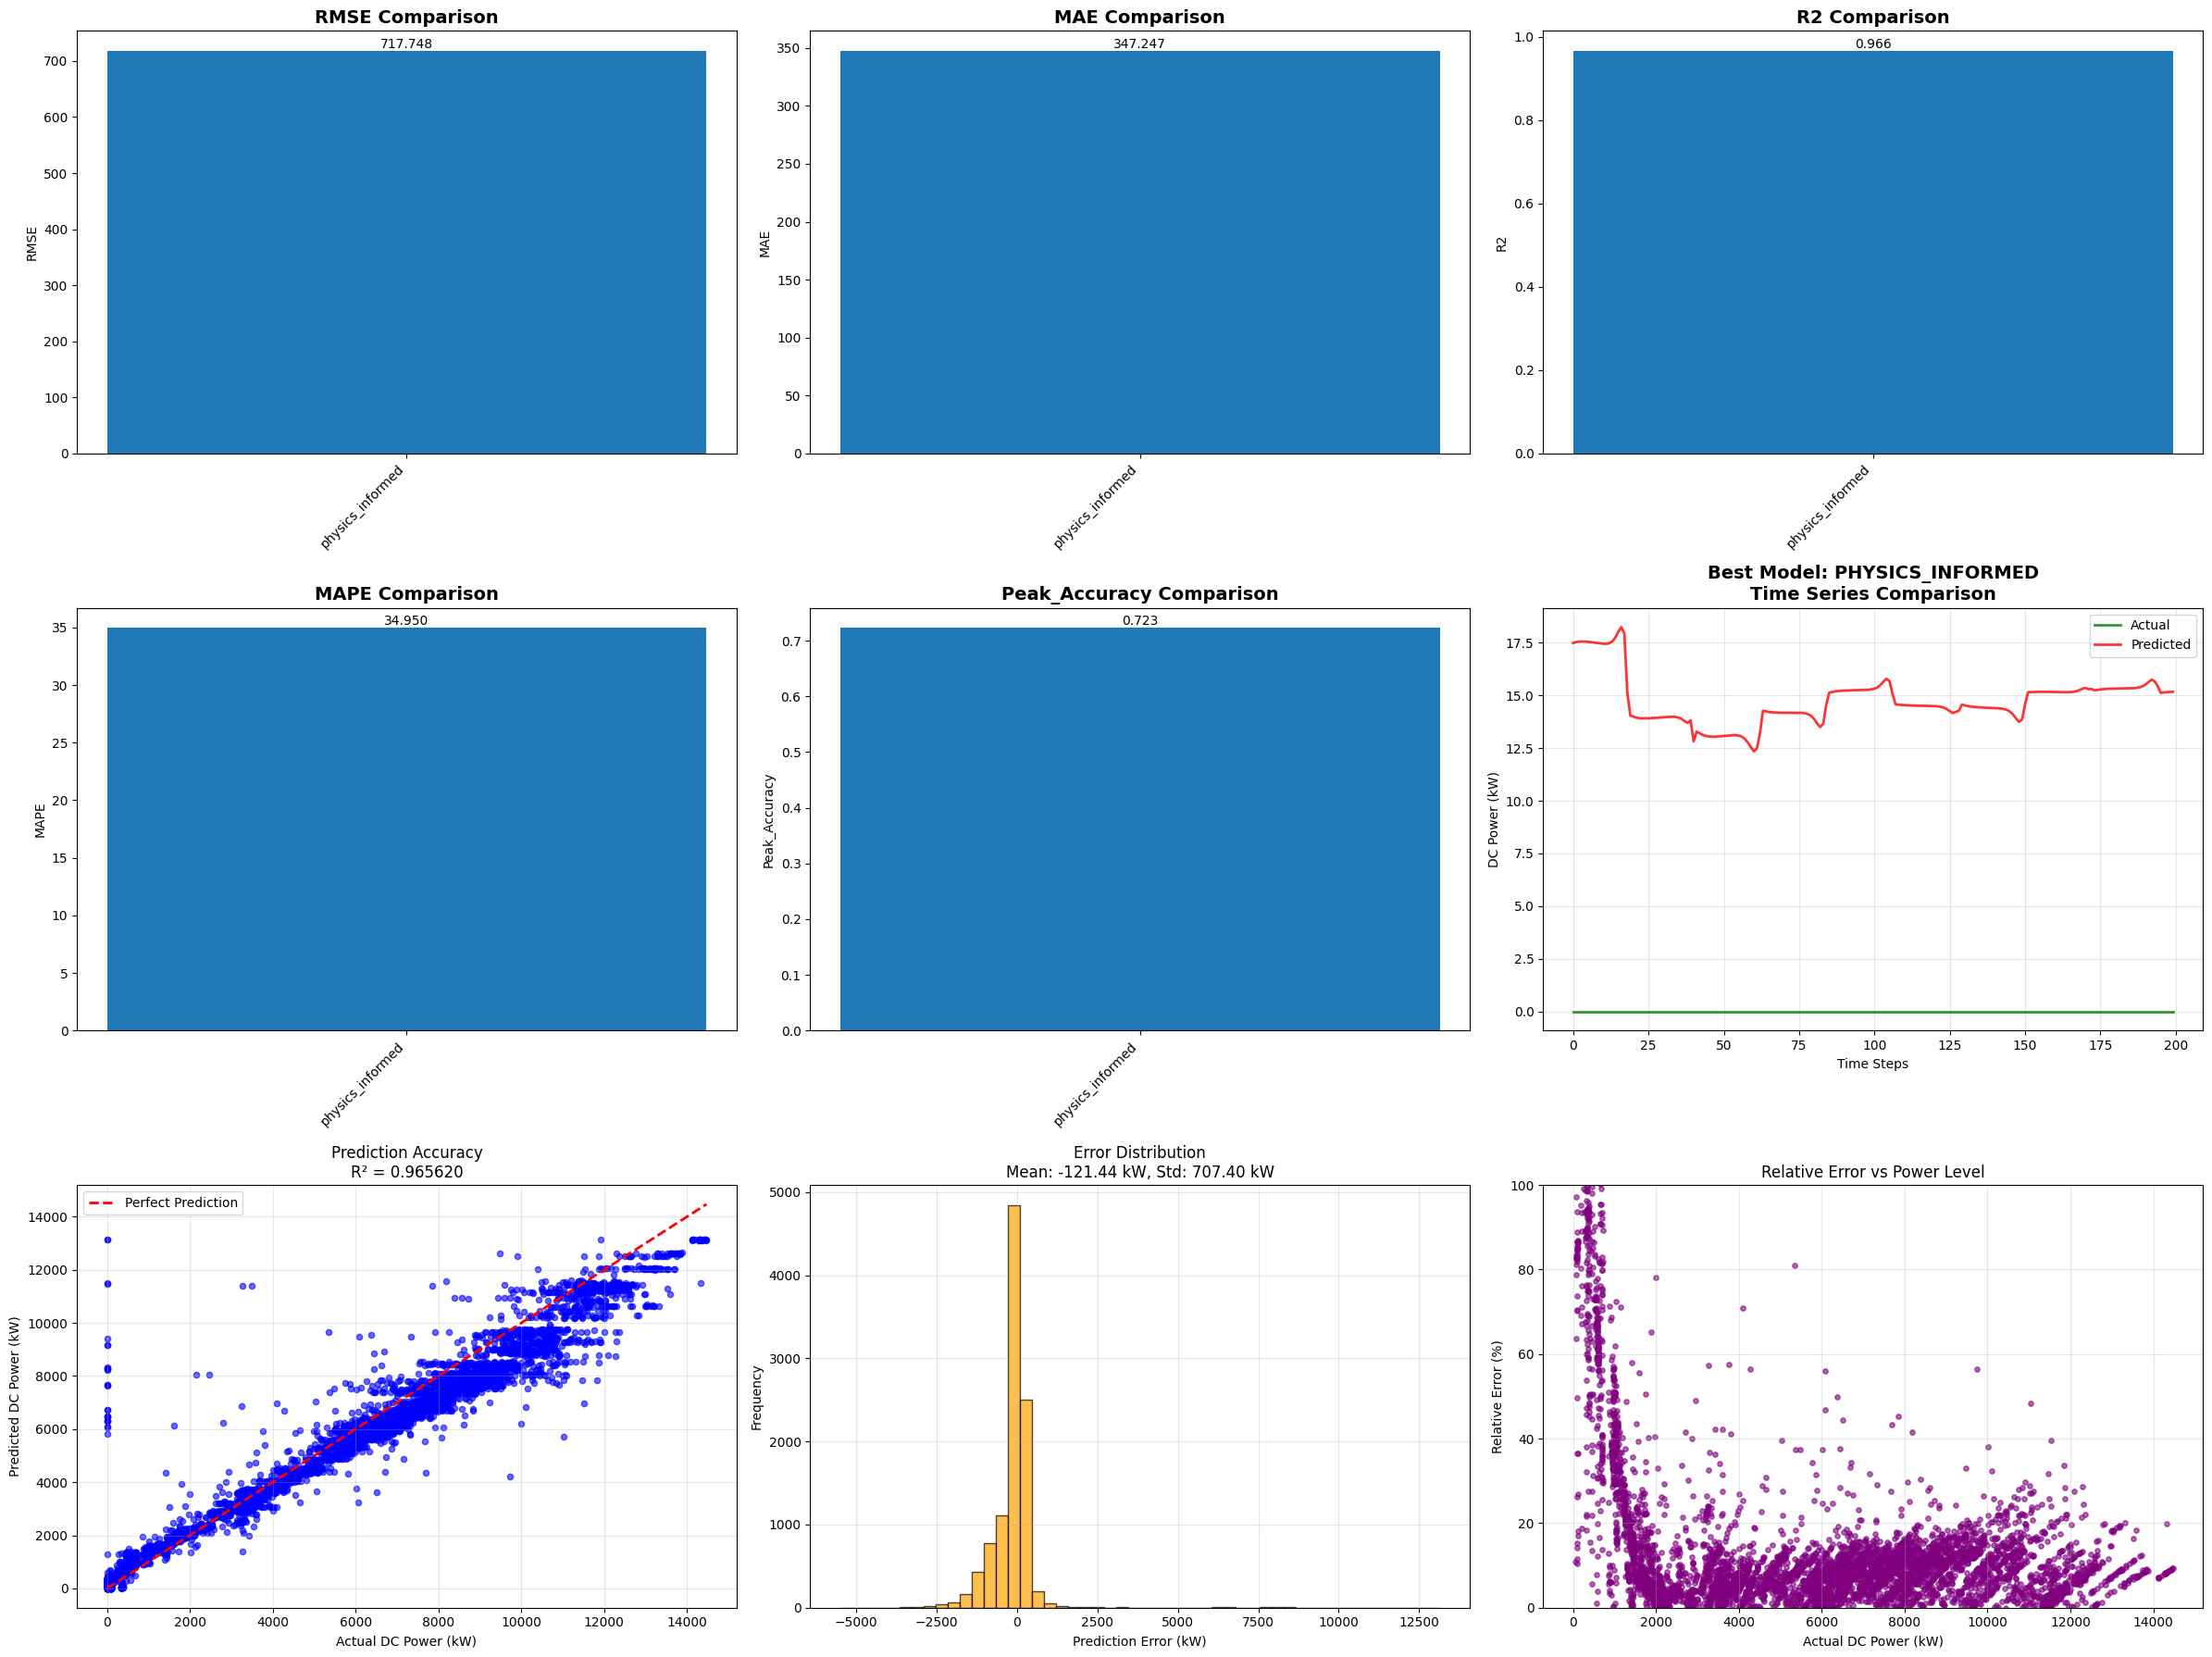


🏆 BEST PERFORMING MODEL: PHYSICS_INFORMED
🎯 R² Score: 0.965620
📊 RMSE: 717.75 kW
🔥 Enhanced features: ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']
⚡ NO SCALING - Preserving natural relationships!


In [7]:
results = run_improved_dc_power_prediction(df_gen1, df_sens1, window_size=24, epochs=150)
best_model = results['models'][results['best_model']]

In [9]:
import pickle
with open('improved_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)



Generating predictions for 1954 timesteps...
Skipping prediction for timestep 0 (2020-05-15 00:00:00): Sequence starts before dataframe beginning.
Skipping prediction for timestep 1 (2020-05-15 00:00:00): Sequence starts before dataframe beginning.
Skipping prediction for timestep 2 (2020-05-15 00:00:00): Sequence starts before dataframe beginning.
Skipping prediction for timestep 3 (2020-05-15 00:00:00): Sequence starts before dataframe beginning.
Skipping prediction for timestep 4 (2020-05-15 00:00:00): Sequence starts before dataframe beginning.
Skipping prediction for timestep 5 (2020-05-15 00:00:00): Sequence starts before dataframe beginning.
Skipping prediction for timestep 6 (2020-05-15 00:00:00): Sequence starts before dataframe beginning.
Skipping prediction for timestep 7 (2020-05-15 00:00:00): Sequence starts before dataframe beginning.
Skipping prediction for timestep 8 (2020-05-15 00:00:00): Sequence starts before dataframe beginning.
Skipping prediction for timestep 9 (

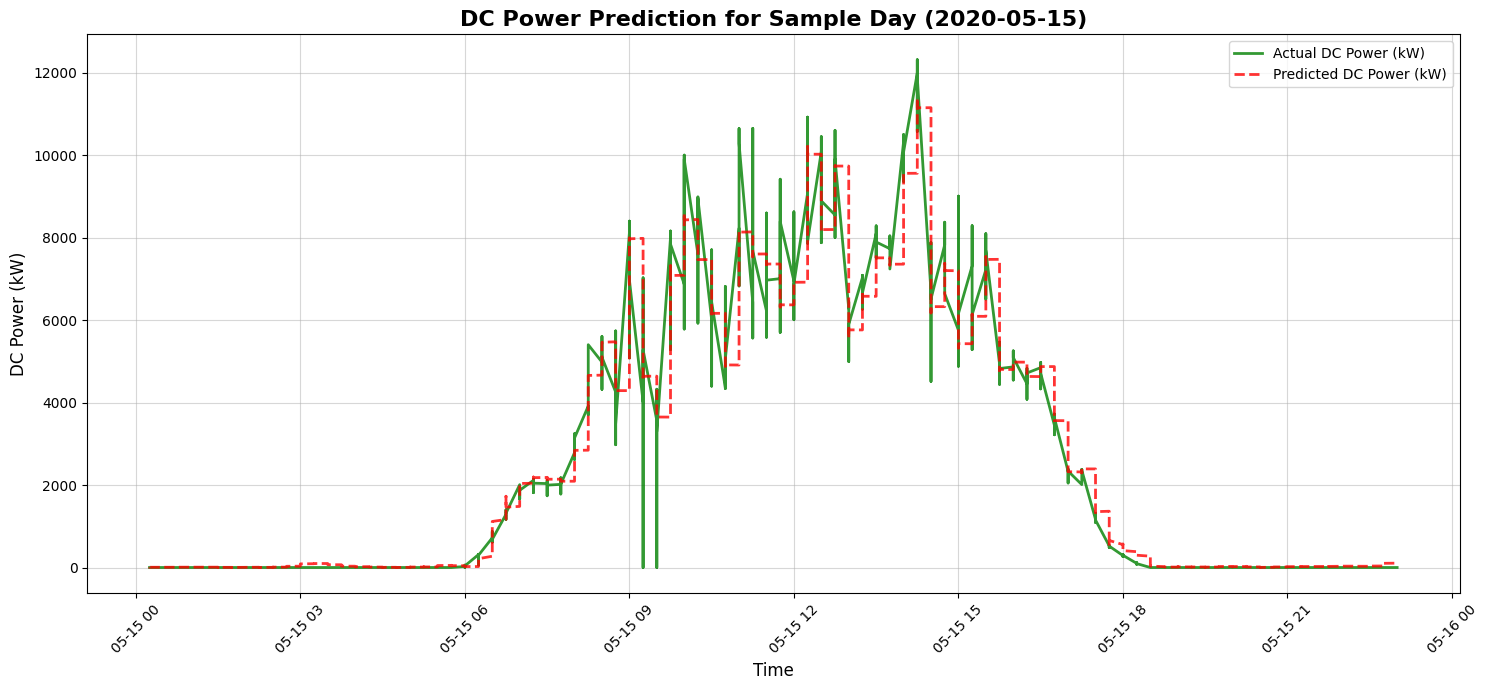


Metrics for the Predicted Day (2020-05-15):
  RMSE: 601.75 kW
  MAE:  301.13 kW
  R²:   0.969272


In [16]:
# prompt: check the predicted to actual values for 1 day and draw a graph

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Select a full day's worth of weather data (48 timesteps) from df_combined_full
# Replace '2020-05-15' with a date that exists in your df_combined_full
sample_date = '2020-05-15' # Example date, change if needed
day_data = df_combined_full[df_combined_full['DATE_TIME'].dt.date == pd.to_datetime(sample_date).date()].copy()

# Ensure we have 48 data points for a full day
if len(day_data) < 48:
    print(f"Warning: Could not find a full 48 timesteps for date {sample_date}. Found {len(day_data)}.")
    print("Attempting to use the last 48 points from the dataset instead.")
    # Use the last 48 points if a full day isn't available for the chosen date
    day_data = df_combined_full.iloc[-48:].copy() # Use .copy()
    if len(day_data) < 48:
        print("Error: Not enough data even at the end of the dataset.")
        day_data = pd.DataFrame() # Empty dataframe to prevent errors


if not day_data.empty:
    # Ensure we have the required features and sort by time
    # Keep 'DATE_TIME' column for plotting
    required_cols = feature_names + ['DATE_TIME', 'DC_POWER'] # Need actual DC_POWER for plotting
    missing_day_cols = [col for col in required_cols if col not in day_data.columns]
    if missing_day_cols:
        print(f"Error: Missing required columns in day_data: {missing_day_cols}")
        day_data = pd.DataFrame() # Empty dataframe to prevent errors
    else:
        day_data = day_data[required_cols].sort_values('DATE_TIME').reset_index(drop=True)

if not day_data.empty:
    print(f"\nGenerating predictions for {len(day_data)} timesteps...")

    predictions_for_day = []
    # We will plot the actual values from the 'day_data' dataframe
    actual_for_day = day_data['DC_POWER'].values
    timestamps_for_day = day_data['DATE_TIME']

    # The model predicts one step ahead. To predict for each timestep in `day_data`,
    # we need a sequence of length `window_size` *ending right before* that timestep.

    # Find the index of the first timestamp of `day_data` within the full combined dataframe
    start_date_time_day = day_data['DATE_TIME'].iloc[0]
    try:
        start_index_full = df_combined_full[df_combined_full['DATE_TIME'] == start_date_time_day].index[0]
    except IndexError:
        print(f"Error: Start timestamp of selected day ({start_date_time_day}) not found in the full dataframe.")
        start_index_full = -1 # Indicate error

    if start_index_full != -1:
        # Iterate through each timestep in the selected day
        for i in range(len(day_data)):
            # The index in the full dataframe corresponding to the current timestep in day_data
            current_index_full = start_index_full + i

            # Check if we have enough preceding data in the full dataframe to form the window
            # We need data from `current_index_full - window_size` up to `current_index_full - 1`
            sequence_start_index_full = current_index_full - window_size
            sequence_end_index_full = current_index_full # The model input is the window, output is the next step (current_index_full)

            if sequence_start_index_full >= 0:
                # Extract the sequence of features from the full dataframe
                input_sequence_df = df_combined_full.iloc[sequence_start_index_full : sequence_end_index_full]

                if len(input_sequence_df) == window_size:
                     input_sequence_values = input_sequence_df[feature_names].values.astype(np.float32)
                     input_sequence = input_sequence_values.reshape(1, window_size, len(feature_names))

                     # Make prediction for the current timestep
                     predicted_power = best_model.predict(input_sequence, verbose=0).flatten()[0]
                     predicted_power = max(0, predicted_power) # Ensure non-negative
                     predictions_for_day.append(predicted_power)
                else:
                     print(f"Skipping prediction for timestep {i} ({timestamps_for_day.iloc[i]}): Not enough preceding data for window ({len(input_sequence_df)}/{window_size}).")
                     predictions_for_day.append(np.nan) # Append NaN if window cannot be formed
            else:
                print(f"Skipping prediction for timestep {i} ({timestamps_for_day.iloc[i]}): Sequence starts before dataframe beginning.")
                predictions_for_day.append(np.nan) # Append NaN if window cannot be formed


        # Convert predictions to numpy array
        predictions_for_day = np.array(predictions_for_day)

        # Filter out NaN values if any were added due to missing windows at the start
        valid_mask = ~np.isnan(predictions_for_day)
        predictions_for_day = predictions_for_day[valid_mask]
        actual_for_day = actual_for_day[valid_mask]
        timestamps_for_day = timestamps_for_day[valid_mask]


        print(f"Generated {len(predictions_for_day)} valid predictions for the day.")


        # Plotting the predictions against actual values for the selected day
        plt.figure(figsize=(15, 7))
        plt.plot(timestamps_for_day, actual_for_day, label='Actual DC Power (kW)', linewidth=2, alpha=0.8, color='green')
        plt.plot(timestamps_for_day, predictions_for_day, label='Predicted DC Power (kW)', linewidth=2, alpha=0.8, color='red', linestyle='--')

        plt.title(f'DC Power Prediction for Sample Day ({sample_date})', fontsize=16, fontweight='bold')
        plt.xlabel('Time', fontsize=12)
        plt.ylabel('DC Power (kW)', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.5)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Calculate metrics for the predicted day
        if len(actual_for_day) > 0:
            day_mse = mean_squared_error(actual_for_day, predictions_for_day)
            day_rmse = np.sqrt(day_mse)
            day_mae = mean_absolute_error(actual_for_day, predictions_for_day)
            day_r2 = r2_score(actual_for_day, predictions_for_day)

            print(f"\nMetrics for the Predicted Day ({sample_date}):")
            print(f"  RMSE: {day_rmse:.2f} kW")
            print(f"  MAE:  {day_mae:.2f} kW")
            print(f"  R²:   {day_r2:.6f}")
        else:
            print("\nNo valid predictions were generated for the selected day to calculate metrics.")
    else:
         print("\nCould not find the start of the selected day in the full dataframe.")

else:
    print(f"\nCould not find or prepare valid data for prediction for date {sample_date}.")


Preparing dataset WITHOUT scaling...
Combined dataset shape: (68774, 5)
Date range: 2020-05-15 00:00:00 to 2020-06-17 23:45:00
DC Power range: 0.0 to 14471.1 kW
Irradiation range: 0.0 to 1.2
Temperature range: 20.4 to 35.3°C
Found 2112 timesteps for date 2020-06-13.

Generating predictions for 2112 timesteps...
Generated 2112 valid predictions for the day.


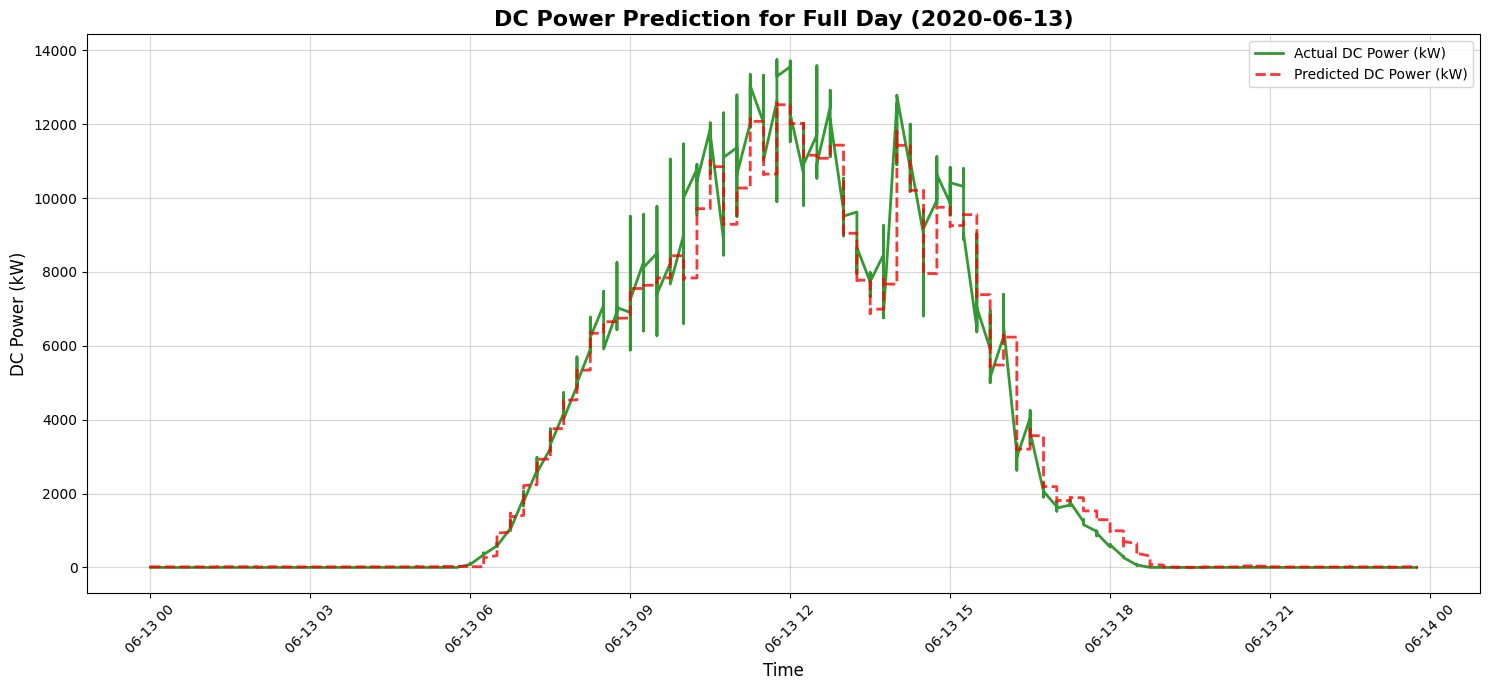


Metrics for the Predicted Day (2020-06-13):
  RMSE: 642.76 kW
  MAE:  355.18 kW
  R²:   0.980407


In [19]:


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_combined_full = prepare_data_no_scaling(df_gen1, df_sens1)

# Select data for the specific date '2020-06-13'
sample_date = '2020-06-13'
day_data = df_combined_full[df_combined_full['DATE_TIME'].dt.date == pd.to_datetime(sample_date).date()].copy()

# Ensure we have data for the selected day
if day_data.empty:
    print(f"Error: No data found for date {sample_date}.")
    print("Please check if this date exists in your dataset.")
else:
    print(f"Found {len(day_data)} timesteps for date {sample_date}.")

    # Ensure we have the required features and sort by time
    # Keep 'DATE_TIME' column for plotting and 'DC_POWER' for actual values
    required_cols = feature_names + ['DATE_TIME', 'DC_POWER'] # Assumes feature_names is defined
    missing_day_cols = [col for col in required_cols if col not in day_data.columns]
    if missing_day_cols:
        print(f"Error: Missing required columns in day_data: {missing_day_cols}")
        day_data = pd.DataFrame() # Empty dataframe to prevent errors
    else:
        day_data = day_data[required_cols].sort_values('DATE_TIME').reset_index(drop=True)

    if not day_data.empty:
        print(f"\nGenerating predictions for {len(day_data)} timesteps...")

        predictions_for_day = []
        # We will plot the actual values from the 'day_data' dataframe
        actual_for_day = day_data['DC_POWER'].values
        timestamps_for_day = day_data['DATE_TIME']

        # The model predicts one step ahead. To predict for each timestep in `day_data`,
        # we need a sequence of length `window_size` *ending right before* that timestep.

        # Find the index of the first timestamp of `day_data` within the full combined dataframe
        start_date_time_day = day_data['DATE_TIME'].iloc[0]
        try:
            start_index_full = df_combined_full[df_combined_full['DATE_TIME'] == start_date_time_day].index[0]
        except IndexError:
            print(f"Error: Start timestamp of selected day ({start_date_time_day}) not found in the full dataframe.")
            start_index_full = -1 # Indicate error

        if start_index_full != -1:
            # Iterate through each timestep in the selected day
            for i in range(len(day_data)):
                # The index in the full dataframe corresponding to the current timestep in day_data
                current_index_full = start_index_full + i

                # Check if we have enough preceding data in the full dataframe to form the window
                # We need data from `current_index_full - window_size` up to `current_index_full - 1`
                sequence_start_index_full = current_index_full - window_size
                sequence_end_index_full = current_index_full # The model input is the window, output is the next step (current_index_full)

                if sequence_start_index_full >= 0:
                    # Extract the sequence of features from the full dataframe
                    input_sequence_df = df_combined_full.iloc[sequence_start_index_full : sequence_end_index_full]

                    if len(input_sequence_df) == window_size:
                         # Ensure only feature columns are used for prediction input
                         input_sequence_values = input_sequence_df[feature_names].values.astype(np.float32)
                         input_sequence = input_sequence_values.reshape(1, window_size, len(feature_names))

                         # Make prediction for the current timestep
                         # Assumes best_model is available and loaded
                         if 'best_model' in locals() and isinstance(best_model, tf.keras.Model):
                            predicted_power = best_model.predict(input_sequence, verbose=0).flatten()[0]
                            predicted_power = max(0, predicted_power) # Ensure non-negative
                            predictions_for_day.append(predicted_power)
                         else:
                            print("Error: 'best_model' not found or not a valid Keras Model.")
                            predictions_for_day.append(np.nan)
                            # Break the loop if model is not available
                            break
                    else:
                         print(f"Skipping prediction for timestep {i} ({timestamps_for_day.iloc[i]}): Not enough preceding data for window ({len(input_sequence_df)}/{window_size}).")
                         predictions_for_day.append(np.nan) # Append NaN if window cannot be formed
                else:
                    print(f"Skipping prediction for timestep {i} ({timestamps_for_day.iloc[i]}): Sequence starts before dataframe beginning.")
                    predictions_for_day.append(np.nan) # Append NaN if window cannot be formed


            # Convert predictions to numpy array
            predictions_for_day = np.array(predictions_for_day)

            # Filter out NaN values if any were added due to missing windows at the start
            valid_mask = ~np.isnan(predictions_for_day)
            predictions_for_day = predictions_for_day[valid_mask]
            actual_for_day = actual_for_day[valid_mask] # Filter actuals too
            timestamps_for_day = timestamps_for_day[valid_mask] # Filter timestamps too


            print(f"Generated {len(predictions_for_day)} valid predictions for the day.")

            # Plotting the predictions against actual values for the selected day
            if len(timestamps_for_day) > 0:
                plt.figure(figsize=(15, 7))
                plt.plot(timestamps_for_day, actual_for_day, label='Actual DC Power (kW)', linewidth=2, alpha=0.8, color='green')
                plt.plot(timestamps_for_day, predictions_for_day, label='Predicted DC Power (kW)', linewidth=2, alpha=0.8, color='red', linestyle='--')

                plt.title(f'DC Power Prediction for Full Day ({sample_date})', fontsize=16, fontweight='bold')
                plt.xlabel('Time', fontsize=12)
                plt.ylabel('DC Power (kW)', fontsize=12)
                plt.legend()
                plt.grid(True, alpha=0.5)
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()

                # Calculate metrics for the predicted day
                if len(actual_for_day) > 0:
                    day_mse = mean_squared_error(actual_for_day, predictions_for_day)
                    day_rmse = np.sqrt(day_mse)
                    day_mae = mean_absolute_error(actual_for_day, predictions_for_day)
                    day_r2 = r2_score(actual_for_day, predictions_for_day)

                    print(f"\nMetrics for the Predicted Day ({sample_date}):")
                    print(f"  RMSE: {day_rmse:.2f} kW")
                    print(f"  MAE:  {day_mae:.2f} kW")
                    print(f"  R²:   {day_r2:.6f}")
                else:
                    print("\nNo valid predictions were generated for the selected day to calculate metrics.")
            else:
                 print("\nNo valid data points with predictions were available to plot for this day.")

        else:
             print("\nCould not find the start of the selected day in the full dataframe.")

    else:
        print(f"\nCould not find or prepare valid data for prediction for date {sample_date}.")



In [21]:
# prompt: show the date ranges in each train test and validation set

import pandas as pd
# Determine the date range for each split
if 'df_combined_full' in locals() and isinstance(df_combined_full, pd.DataFrame):
    total_sequences = len(df_combined_full) - window_size
    train_sequence_size = int(total_sequences * 0.7) # Assuming train_ratio = 0.7
    val_sequence_size = int(total_sequences * 0.15) # Assuming val_ratio = 0.15

    # The dates being predicted by the sequences are `window_size` steps ahead
    # of the start of the sequence.

    # Train set sequences predict data from index window_size to window_size + train_sequence_size - 1
    train_dates_start_idx = window_size
    train_dates_end_idx = window_size + train_sequence_size - 1

    # Validation set sequences predict data from index window_size + train_sequence_size
    # to window_size + train_sequence_size + val_sequence_size - 1
    val_dates_start_idx = window_size + train_sequence_size
    val_dates_end_idx = window_size + train_sequence_size + val_sequence_size - 1

    # Test set sequences predict data from index window_size + train_sequence_size + val_sequence_size
    # to window_size + total_sequences - 1 (which is len(df_combined_full) - 1)
    test_dates_start_idx = window_size + train_sequence_size + val_sequence_size
    test_dates_end_idx = len(df_combined_full) - 1 # The last predicted point corresponds to the last row in df_combined_full

    print("\nDate Ranges for Data Splits (Dates of the PREDICTED points):")
    # Ensure indices are within the bounds of df_combined_full before accessing
    if train_dates_start_idx < len(df_combined_full) and train_dates_end_idx < len(df_combined_full) and train_dates_start_idx <= train_dates_end_idx:
         print(f"Train Set:      {df_combined_full['DATE_TIME'].iloc[train_dates_start_idx].date()} to {df_combined_full['DATE_TIME'].iloc[train_dates_end_idx].date()}")
    else:
         print("Train Set:      Date range could not be determined (indices out of bounds or empty).")

    if val_dates_start_idx < len(df_combined_full) and val_dates_end_idx < len(df_combined_full) and val_dates_start_idx <= val_dates_end_idx:
         print(f"Validation Set: {df_combined_full['DATE_TIME'].iloc[val_dates_start_idx].date()} to {df_combined_full['DATE_TIME'].iloc[val_dates_end_idx].date()}")
    else:
         print("Validation Set: Date range could not be determined (indices out of bounds or empty).")

    if test_dates_start_idx < len(df_combined_full) and test_dates_end_idx < len(df_combined_full) and test_dates_start_idx <= test_dates_end_idx:
         print(f"Test Set:       {df_combined_full['DATE_TIME'].iloc[test_dates_start_idx].date()} to {df_combined_full['DATE_TIME'].iloc[test_dates_end_idx].date()}")
    else:
         print("Test Set:       Date range could not be determined (indices out of bounds or empty).")

else:
    print("df_combined_full is not available. Cannot determine date ranges for splits.")
    print("Please run the preceding data preparation steps first.")


Date Ranges for Data Splits (Dates of the PREDICTED points):
Train Set:      2020-05-15 to 2020-06-08
Validation Set: 2020-06-08 to 2020-06-13
Test Set:       2020-06-13 to 2020-06-17


Preparing dataset WITHOUT scaling...
Combined dataset shape: (68774, 5)
Date range: 2020-05-15 00:00:00 to 2020-06-17 23:45:00
DC Power range: 0.0 to 14471.1 kW
Irradiation range: 0.0 to 1.2
Temperature range: 20.4 to 35.3°C
Found 2112 timesteps for date 2020-06-16.

Generating predictions for 2112 timesteps...
Generated 2112 valid predictions for the day.


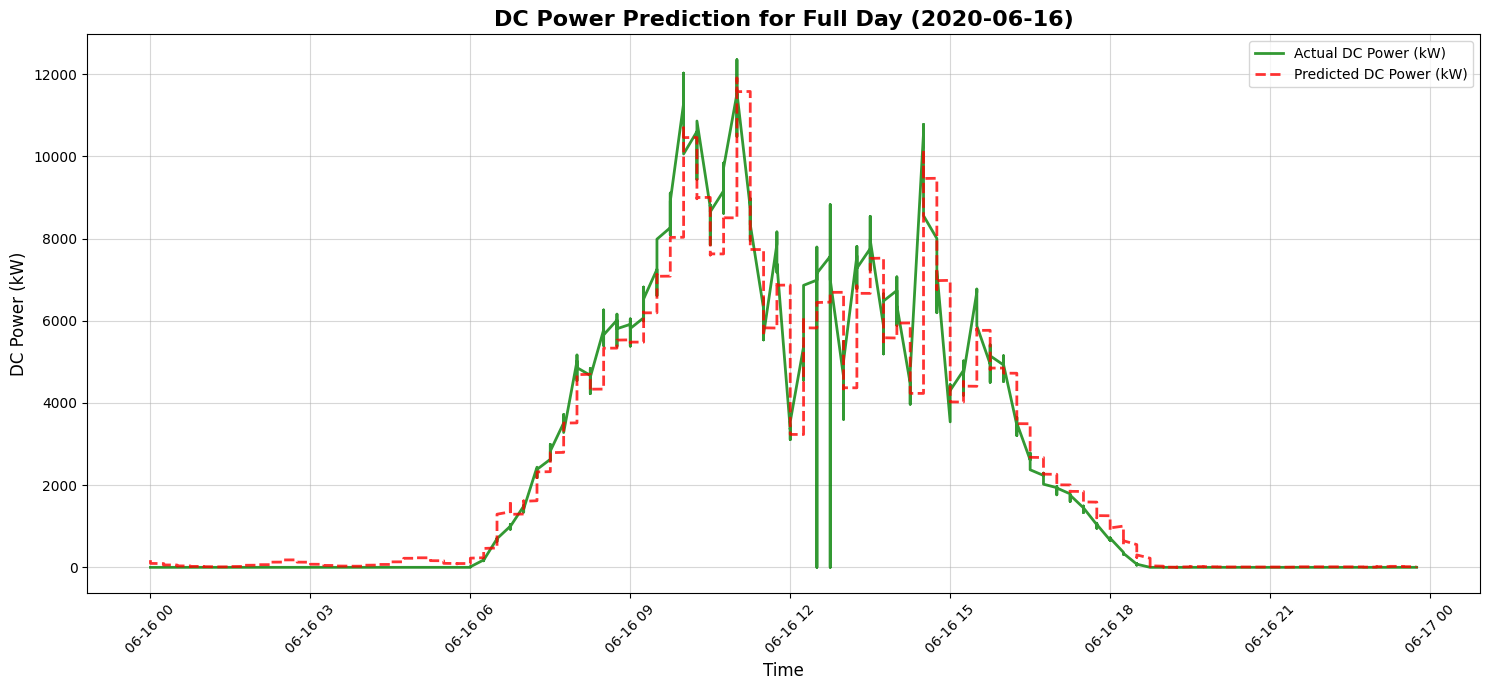


Metrics for the Predicted Day (2020-06-16):
  RMSE: 515.09 kW
  MAE:  268.96 kW
  R²:   0.976521


In [24]:
# prompt: make graph for the full day 2020-06-16 using the model to predict

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Prepare the full combined dataframe again to easily access real weather data
# This step assumes df_gen1 and df_sens1 are available from the preceding code
df_combined_full = prepare_data_no_scaling(df_gen1, df_sens1)

# Select data for the specific date '2020-06-16'
sample_date = '2020-06-16'
day_data = df_combined_full[df_combined_full['DATE_TIME'].dt.date == pd.to_datetime(sample_date).date()].copy()

# Ensure we have data for the selected day
if day_data.empty:
    print(f"Error: No data found for date {sample_date}.")
    print("Please check if this date exists in your dataset.")
else:
    print(f"Found {len(day_data)} timesteps for date {sample_date}.")

    # Ensure we have the required features and sort by time
    # Keep 'DATE_TIME' column for plotting and 'DC_POWER' for actual values
    # Assumes feature_names is defined and contains ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']
    # Assumes window_size is defined
    required_cols = feature_names + ['DATE_TIME', 'DC_POWER']
    missing_day_cols = [col for col in required_cols if col not in day_data.columns]
    if missing_day_cols:
        print(f"Error: Missing required columns in day_data: {missing_day_cols}")
        day_data = pd.DataFrame() # Empty dataframe to prevent errors
    else:
        day_data = day_data[required_cols].sort_values('DATE_TIME').reset_index(drop=True)

    if not day_data.empty:
        print(f"\nGenerating predictions for {len(day_data)} timesteps...")

        predictions_for_day = []
        # We will plot the actual values from the 'day_data' dataframe
        actual_for_day = day_data['DC_POWER'].values
        timestamps_for_day = day_data['DATE_TIME']

        # The model predicts one step ahead. To predict for each timestep in `day_data`,
        # we need a sequence of length `window_size` *ending right before* that timestep.

        # Find the index of the first timestamp of `day_data` within the full combined dataframe
        start_date_time_day = day_data['DATE_TIME'].iloc[0]
        try:
            start_index_full = df_combined_full[df_combined_full['DATE_TIME'] == start_date_time_day].index[0]
        except IndexError:
            print(f"Error: Start timestamp of selected day ({start_date_time_day}) not found in the full dataframe.")
            start_index_full = -1 # Indicate error

        if start_index_full != -1:
            # Iterate through each timestep in the selected day
            for i in range(len(day_data)):
                # The index in the full dataframe corresponding to the current timestep in day_data
                current_index_full = start_index_full + i

                # Check if we have enough preceding data in the full dataframe to form the window
                # We need data from `current_index_full - window_size` up to `current_index_full - 1`
                sequence_start_index_full = current_index_full - window_size
                sequence_end_index_full = current_index_full # The model input is the window, output is the next step (current_index_full)

                if sequence_start_index_full >= 0:
                    # Extract the sequence of features from the full dataframe
                    input_sequence_df = df_combined_full.iloc[sequence_start_index_full : sequence_end_index_full]

                    if len(input_sequence_df) == window_size:
                         # Ensure only feature columns are used for prediction input
                         input_sequence_values = input_sequence_df[feature_names].values.astype(np.float32)
                         input_sequence = input_sequence_values.reshape(1, window_size, len(feature_names))

                         # Make prediction for the current timestep
                         # Assumes best_model is available and loaded
                         if 'best_model' in locals() and isinstance(best_model, tf.keras.Model):
                            predicted_power = best_model.predict(input_sequence, verbose=0).flatten()[0]
                            predicted_power = max(0, predicted_power) # Ensure non-negative
                            predictions_for_day.append(predicted_power)
                         else:
                            print("Error: 'best_model' not found or not a valid Keras Model.")
                            predictions_for_day.append(np.nan)
                            # Break the loop if model is not available
                            break
                    else:
                         print(f"Skipping prediction for timestep {i} ({timestamps_for_day.iloc[i]}): Not enough preceding data for window ({len(input_sequence_df)}/{window_size}).")
                         predictions_for_day.append(np.nan) # Append NaN if window cannot be formed
                else:
                    print(f"Skipping prediction for timestep {i} ({timestamps_for_day.iloc[i]}): Sequence starts before dataframe beginning.")
                    predictions_for_day.append(np.nan) # Append NaN if window cannot be formed


            # Convert predictions to numpy array
            predictions_for_day = np.array(predictions_for_day)

            # Filter out NaN values if any were added due to missing windows at the start
            valid_mask = ~np.isnan(predictions_for_day)
            predictions_for_day = predictions_for_day[valid_mask]
            actual_for_day = actual_for_day[valid_mask] # Filter actuals too
            timestamps_for_day = timestamps_for_day[valid_mask] # Filter timestamps too


            print(f"Generated {len(predictions_for_day)} valid predictions for the day.")

            # Plotting the predictions against actual values for the selected day
            if len(timestamps_for_day) > 0:
                plt.figure(figsize=(15, 7))
                plt.plot(timestamps_for_day, actual_for_day, label='Actual DC Power (kW)', linewidth=2, alpha=0.8, color='green')
                plt.plot(timestamps_for_day, predictions_for_day, label='Predicted DC Power (kW)', linewidth=2, alpha=0.8, color='red', linestyle='--')

                plt.title(f'DC Power Prediction for Full Day ({sample_date})', fontsize=16, fontweight='bold')
                plt.xlabel('Time', fontsize=12)
                plt.ylabel('DC Power (kW)', fontsize=12)
                plt.legend()
                plt.grid(True, alpha=0.5)
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()

                # Calculate metrics for the predicted day
                if len(actual_for_day) > 0:
                    day_mse = mean_squared_error(actual_for_day, predictions_for_day)
                    day_rmse = np.sqrt(day_mse)
                    day_mae = mean_absolute_error(actual_for_day, predictions_for_day)
                    day_r2 = r2_score(actual_for_day, predictions_for_day)

                    print(f"\nMetrics for the Predicted Day ({sample_date}):")
                    print(f"  RMSE: {day_rmse:.2f} kW")
                    print(f"  MAE:  {day_mae:.2f} kW")
                    print(f"  R²:   {day_r2:.6f}")
                else:
                    print("\nNo valid predictions were generated for the selected day to calculate metrics.")
            else:
                 print("\nNo valid data points with predictions were available to plot for this day.")

        else:
             print("\nCould not find the start of the selected day in the full dataframe.")

    else:
        print(f"\nCould not find or prepare valid data for prediction for date {sample_date}.")
